# Importando módulos 

In [1]:
import obspy
from obspy.taup import TauPyModel

from multiprocessing import Pool
from obspy import read,UTCDateTime,Trace
from obspy.clients.fdsn import Client
import os
import glob
import numpy as np
from collections import defaultdict
import pandas as pd

#para plotar as figuras
import matplotlib.pyplot as plt
from matplotlib.transforms import offset_copy
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import ListedColormap
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition,inset_axes
import matplotlib.colors as colors
import matplotlib.cm as cm
from matplotlib.dates import YearLocator, MonthLocator, DayLocator, HourLocator, MinuteLocator, SecondLocator, DateFormatter
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
import matplotlib.gridspec as gridspec

from datetime import datetime,timedelta,date
from tqdm import tqdm

from shapely.geometry.polygon import LinearRing

import cartopy.io.shapereader as shpreader
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Inputs e Outputs

In [2]:
FOLDER_OUTPUT = '/run/media/dIOGOLOC/8d2362fc-3b46-49a7-a864-19b2a6ad097b/diogoloc/dados_posdoc/gliders_project/OUTPUT/'

MSEED_INPUT = "/run/media/dIOGOLOC/8d2362fc-3b46-49a7-a864-19b2a6ad097b/diogoloc/dados_posdoc/gliders_project/OUTPUT/MSEED/"

EVENTs_DATA_FOLDER = '/home/diogoloc/Documents/codes_marefone/EVENT_MSEED/'

SELECT_EVENTs_DATA_FOLDER = '/home/diogoloc/Documents/codes_marefone/EVENT_MSEED_SEL/'

METADATA_OUTPUT = "/run/media/dIOGOLOC/8d2362fc-3b46-49a7-a864-19b2a6ad097b/diogoloc/dados_posdoc/gliders_project/gliders_data/info_csv/metadados_glider_acustico_pmpas-bs.csv"

# Extraindo informações dos arquivos ".mseed"

In [3]:
filenames_MSEED = sorted(glob.glob(MSEED_INPUT+'*/*/*.mseed'))

In [4]:
len(filenames_MSEED)

0

In [4]:
def mseed_data_2_dataframe(i):
    subdir, filename_wav = os.path.split(i)
    filename = filename_wav.split('.mseed')[0]
    if 'pa' in filename.split('_')[0]:
        mergulho = filename.split('_')[0].split('a')[1]
        stream_number = filename.split('_')[1]

        year_month_day = filename.split('_')[2]
        hour_minute_second = filename.split('_')[3]

        year = int('20'+year_month_day[:2])
        month = int(year_month_day[2:4])
        day = int(year_month_day[4:])

        hour = int(hour_minute_second[:2])
        minute = int(hour_minute_second[2:4])
        second = int(hour_minute_second[4:])

        d = UTCDateTime(datetime(year,month,day,hour,minute,second).isoformat())


    if 'pa' in filename.split('_')[2]:

        mergulho = filename.split('_')[2].split('a')[1]
        stream_number = filename.split('_')[3]

        year_month_day = filename.split('_')[0]
        hour_minute_second = filename.split('_')[1]

        year = int('20'+year_month_day[:2])
        month = int(year_month_day[2:4])
        day = int(year_month_day[4:])

        hour = int(hour_minute_second[:2])
        minute = int(hour_minute_second[2:4])
        second = int(hour_minute_second[4:])

        d = UTCDateTime(datetime(year,month,day,hour,minute,second).isoformat())
        
    
    st = read(i,headonly=True)   
    #----------------------------
    #Starting Dataframe

    starttime = st[0].stats.starttime.datetime
    endtime = st[0].stats.endtime.datetime
    
    df = pd.DataFrame([[filename],[mergulho],[stream_number],[starttime],[endtime]], index=['filename', 'mergulho', 'stream_number','starttime','endtime']).T
    
    #Ending Dataframe
    #----------------------------
    return df

In [5]:
pandas_mseed_lst = []

with Pool(processes=8) as p:
    max_ = len(filenames_MSEED)
    with tqdm(total=max_) as pbar:
        for result in p.imap_unordered(mseed_data_2_dataframe,filenames_MSEED):
            pbar.update()
            pandas_mseed_lst.append(result)

100%|████████████████████████████████████| 10093/10093 [00:25<00:00, 395.08it/s]


In [6]:
dataframe_mseed_final = pd.concat(pandas_mseed_lst, ignore_index=True)


In [7]:
dataframe_mseed_final

,filename,mergulho,stream_number,starttime,endtime
0,pa0001au_008_190210_151934,0001,008,2019-02-10 15:19:34,2019-02-10 15:29:33.990
1,pa0001au_006_190210_145934,0001,006,2019-02-10 14:59:34,2019-02-10 15:09:33.990
2,pa0001au_001_190210_140934,0001,001,2019-02-10 14:09:34,2019-02-10 14:19:33.990
3,pa0001au_005_190210_144934,0001,005,2019-02-10 14:49:34,2019-02-10 14:59:33.990
4,pa0001au_010_190210_153934,0001,010,2019-02-10 15:39:34,2019-02-10 15:41:01.400
...,...,...,...,...,...
10088,pa0238au_012_191010_210037,0238,012,2019-10-10 21:00:37,2019-10-10 21:10:36.990
10089,pa0238au_014_191010_212037,0238,014,2019-10-10 21:20:37,2019-10-10 21:30:36.990
10090,pa0238au_017_191010_215037,0238,017,2019-10-10 21:50:37,2019-10-10 21:59:05.130
10091,pa0238au_015_191010_213037,0238,015,2019-10-10 21:30:37,2019-10-10 21:40:36.990


# Extraindo informações dos arquivos ".csv"

In [8]:
filename_csv = '/home/diogoloc/dados_posdoc/glider_ON_petrobras/info_csv/metadados_glider_acustico_pmpas-bs.csv'

In [9]:
dataframe_csv = pd.read_csv(filename_csv,parse_dates=['time'])
dataframe_csv.sort_values(by='time')

,time,filename,latitude,longitude,depth
0,2015-11-12 13:48:40.999995,pa0001au_001_151112_134841_rms_spl3.mat,-23.825157,-42.495483,1.314286
1,2015-11-12 13:49:41.000001,pa0001au_001_151112_134841_rms_spl3.mat,-23.824950,-42.495487,7.415555
2,2015-11-12 13:50:40.999998,pa0001au_002_151112_135041_rms_spl3.mat,-23.824745,-42.495490,15.776000
3,2015-11-12 13:51:41.000004,pa0001au_002_151112_135041_rms_spl3.mat,-23.824540,-42.495495,24.372000
4,2015-11-12 13:52:41.000001,pa0001au_003_151112_135241_rms_spl3.mat,-23.824331,-42.495500,32.912000
...,...,...,...,...,...
547748,2021-11-04 06:52:38.000000,pa0296au_011_211104_064338_rms_spl3.mat,-24.461742,-42.471264,866.012900
547749,2021-11-04 06:53:37.999997,pa0296au_012_211104_065338_rms_spl3.mat,-24.461819,-42.471302,873.586100
547750,2021-11-04 06:54:38.000003,pa0296au_012_211104_065338_rms_spl3.mat,-24.461980,-42.471510,879.579600
547751,2021-11-04 06:55:38.000000,pa0296au_012_211104_065338_rms_spl3.mat,-24.462152,-42.471740,884.380700


In [10]:
dataframe_csv['year'] = dataframe_csv['time'].dt.strftime("%Y")
dataframe_csv['month'] = dataframe_csv['time'].dt.strftime("%m")
dataframe_csv['n_month'] = dataframe_csv['time'].dt.strftime("%b")
dataframe_csv['depth'] = dataframe_csv['depth'] * -1

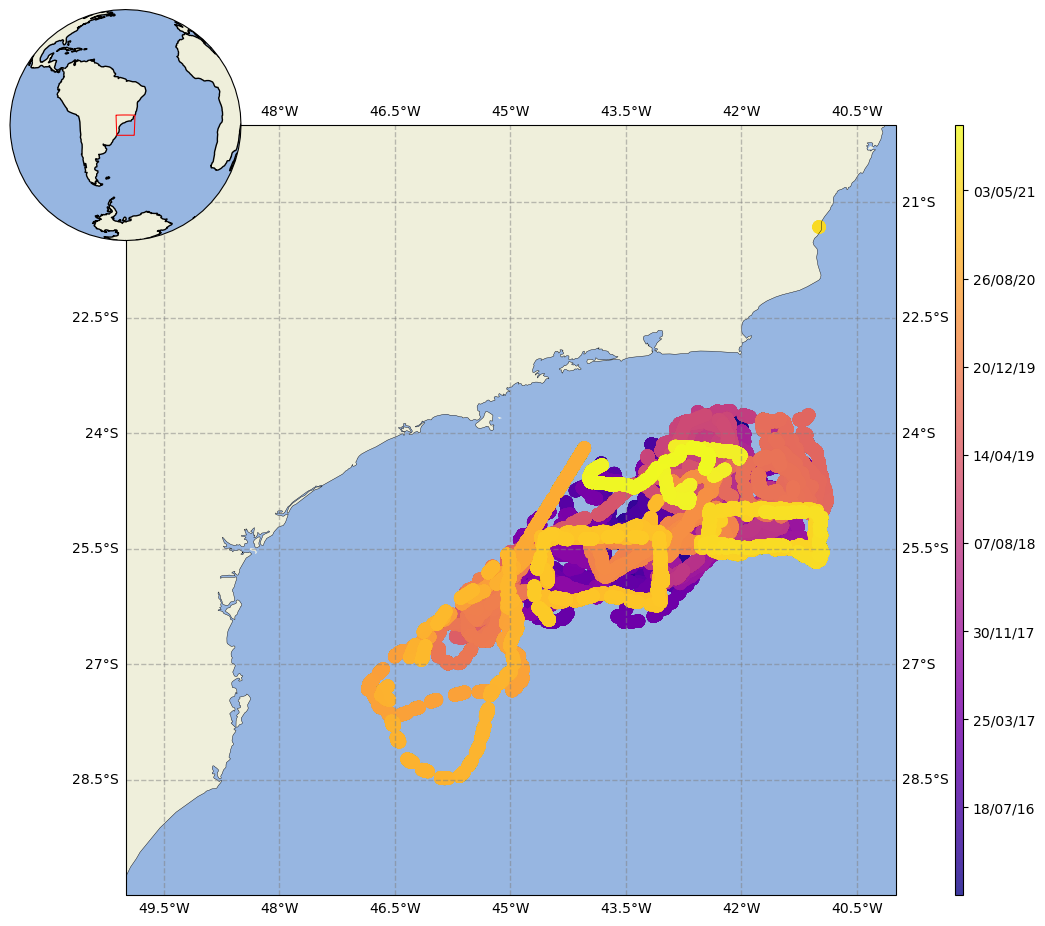

In [11]:
# Create a figure
# set up the plot and create a GeoAxes:
proj = ccrs.PlateCarree()
fig, ax = plt.subplots(1, 1,figsize=(20,10), subplot_kw=dict(projection=proj))

# ----------------------------------------------------------------------------------------------------------
# Limit the extent of the map to a small longitude/latitude range.
latmin=-30
latmax=-20
lonmin=-50
lonmax=-40

ax.set_extent([lonmin,lonmax, latmin, latmax], crs=ccrs.Geodetic())

# ----------------------------------------------------------------------------------------------------------
# Ploting lat/lon values

h = ax.scatter(dataframe_csv['longitude'],dataframe_csv['latitude'],c=np.array([mdates.date2num(obspy.UTCDateTime(i).datetime) for i in dataframe_csv['time']]),marker='o',alpha=0.8,cmap='plasma',s=75,transform=proj)
# ----------------------------------------------------------------------------------------------------------
# Adding background map 
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE,linewidth=0.3)
ax.add_feature(cfeature.BORDERS, linestyle=':',linewidth=0.3)
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1, color='gray', alpha=0.5, linestyle='--')

# ----------------------------------------------------------------------------------------------------------
# Adding colorbar
divider = make_axes_locatable(ax)
ax_cb = divider.new_horizontal(size="1%", pad=0.6, axes_class=plt.Axes)

fig.add_axes(ax_cb)
cb = plt.colorbar(h, cax=ax_cb)
cb.ax.yaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%y'))

#####################################################
# Adding inset axes LEFT
#####################################################

# ----------------------------------------------------------------------------------------------------------
# Adding global location map
# inset location relative to main plot (ax) in normalized units
inset_x = 0
inset_y = 1
inset_size = 0.3
# Adding Geoaxes
ax2 = plt.axes([0, 0, 1, 1], projection=ccrs.Orthographic(central_latitude=(latmin + latmax)/2,central_longitude=(lonmin + lonmax) / 2))
ax2.set_global()

# Adding background map 
ax2.add_feature(cfeature.LAND)
ax2.add_feature(cfeature.OCEAN)
ax2.add_feature(cfeature.COASTLINE)

# Adding inset geoaxes position
ip = InsetPosition(ax, [inset_x - inset_size / 2,
                        inset_y - inset_size / 2,
                        inset_size,
                        inset_size])
ax2.set_axes_locator(ip)


# Adding red rectangle position
nvert = 100
lons = np.r_[np.linspace(lonmin, lonmin, nvert),
             np.linspace(lonmin, lonmax, nvert),
             np.linspace(lonmax, lonmax, nvert)].tolist()
lats = np.r_[np.linspace(latmin, latmax, nvert),
             np.linspace(latmax, latmax, nvert),
             np.linspace(latmax, latmin, nvert)].tolist()

ring = LinearRing(list(zip(lons, lats)))
ax2.add_geometries([ring], ccrs.PlateCarree(),
                   facecolor='none', edgecolor='red', linewidth=0.75)


# Selecionando um evento: 

In [23]:
events_figures = glob.glob(SELECT_EVENTs_DATA_FOLDER+'*')

print("Found %s event(s)" % len(events_figures))

Found 32 event(s)


In [24]:
ev_lst = []
for ev in tqdm(events_figures,total=len(events_figures)):
 
    t = ev.split('event_mseed_')[1].split('.png')[0].split('_')
    
    ev_time = UTCDateTime(datetime(int(t[0]),int(t[1]),int(t[2]),int(t[3]),int(t[4]),int(t[5])).isoformat())
    
    filename = '_'.join(t[6:])
        
    if 'pa' in filename.split('_')[0]:
        mergulho = filename.split('_')[0].split('a')[1]
        stream_number = filename.split('_')[1]

        year_month_day = filename.split('_')[2]
        hour_minute_second = filename.split('_')[3]

        year = int('20'+year_month_day[:2])
        month = int(year_month_day[2:4])
        day = int(year_month_day[4:])

        hour = int(hour_minute_second[:2])
        minute = int(hour_minute_second[2:4])
        second = int(hour_minute_second[4:])

    if 'pa' in filename.split('_')[2]:

        mergulho = filename.split('_')[2].split('a')[1]
        stream_number = filename.split('_')[3]

        year_month_day = filename.split('_')[0]
        hour_minute_second = filename.split('_')[1]

        year = int('20'+year_month_day[:2])
        month = int(year_month_day[2:4])
        day = int(year_month_day[4:])

        
        hour = int(hour_minute_second[:2])
        minute = int(hour_minute_second[2:4])
        second = int(hour_minute_second[4:])

    d = UTCDateTime(datetime(year,month,day,hour,minute,second).isoformat())
    
    #----------------------------
    #Starting Dataframe
    
    df = pd.DataFrame([[filename],[mergulho],[stream_number],[ev_time]], index=['filename', 'mergulho', 'stream_number','event_time']).T
    
    #Ending Dataframe
    #----------------------------
    ev_lst.append(df)

100%|█████████████████████████████████████████| 32/32 [00:00<00:00, 3265.24it/s]


In [25]:
dataframe_ev_file_final = pd.concat(ev_lst, ignore_index=True)


In [26]:
dataframe_ev_file_final.sort_values('event_time')

,filename,mergulho,stream_number,event_time
0,pa0124au_039_151128_054946,0124,039,2015-11-28T05:50:15.000000Z
1,pa0164au_034_160127_151709,0164,034,2016-01-27T15:17:20.000000Z
2,pa0561au_038_160410_072014,0561,038,2016-04-10T07:22:06.000000Z
3,160910_123740_pa0108au_034,0108,034,2016-09-10T12:39:14.000000Z
4,161104_162325_pa0071au_003,0071,003,2016-11-04T16:26:05.000000Z
5,170302_112009_pa0097au_037,0097,037,2017-03-02T11:20:58.000000Z
6,170415_082252_pa0190au_038,0190,038,2017-04-15T08:24:17.000000Z
7,170428_160834_pa0286au_025,0286,025,2017-04-28T16:11:20.000000Z
8,170614_073756_pa0050au_014,0050,014,2017-06-14T07:39:16.000000Z
9,170622_123959_pa0083au_053,0083,053,2017-06-22T12:41:03.000000Z


In [27]:
from matplotlib.backends.backend_pdf import PdfPages
def _draw_as_table(df, pagesize):
    alternating_colors = [['white'] * len(df.columns), ['lightgray'] * len(df.columns)] * len(df)
    alternating_colors = alternating_colors[:len(df)]
    fig, ax = plt.subplots(figsize=pagesize)
    ax.axis('tight')
    ax.axis('off')
    the_table = ax.table(cellText=df.values,
                        rowLabels=df.index,
                        colLabels=df.columns,
                        rowColours=['lightblue']*len(df),
                        colColours=['lightblue']*len(df.columns),
                        cellColours=alternating_colors,
                        loc='center')
    return fig
  

def dataframe_to_pdf(df, filename, numpages=(1, 1), pagesize=(11, 8.5)):
  with PdfPages(filename) as pdf:
    nh, nv = numpages
    rows_per_page = len(df) // nh
    cols_per_page = len(df.columns) // nv
    for i in range(0, nh):
        for j in range(0, nv):
            page = df.iloc[(i*rows_per_page):min((i+1)*rows_per_page, len(df)),
                           (j*cols_per_page):min((j+1)*cols_per_page, len(df.columns))]
            fig = _draw_as_table(page, pagesize)
            if nh > 1 or nv > 1:
                # Add a part/page number at bottom-center of page
                fig.text(0.5, 0.5/pagesize[0],
                         "Part-{}x{}: Page-{}".format(i+1, j+1, i*nv + j + 1),
                         ha='center', fontsize=8)
            pdf.savefig(fig, bbox_inches='tight')
            

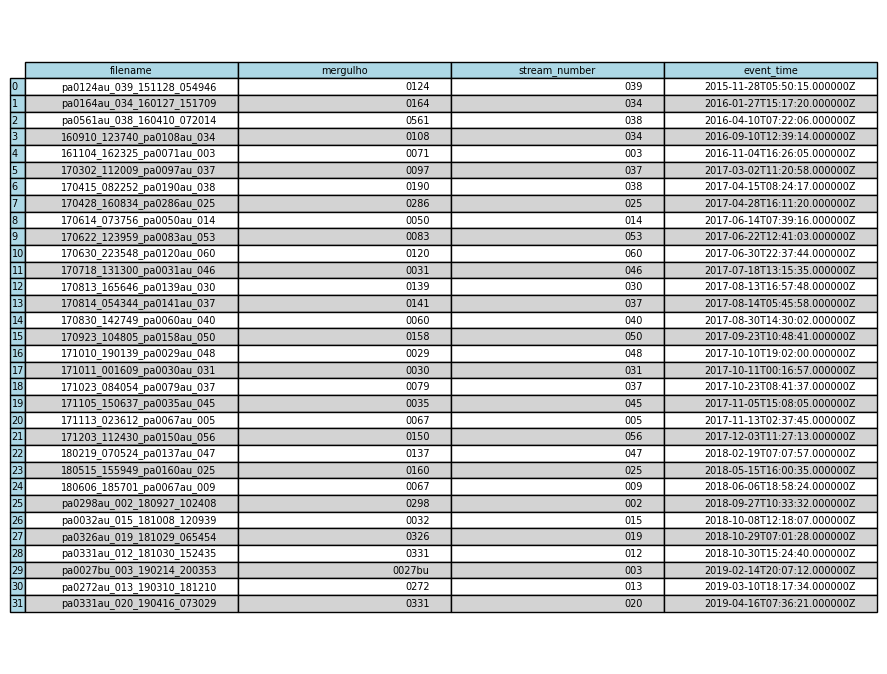

In [28]:
dataframe_to_pdf(dataframe_ev_file_final, 'test_1.pdf')


In [20]:
ev_2019 = []
for i in events_figures:
    if '2019' in i:
        ev_2019.append(i)

In [21]:
for ev in tqdm(ev_2019,total=len(ev_2019)):
 
    t = ev.split('event_mseed_')[1].split('.png')[0].split('_')
    
    ev_time = UTCDateTime(datetime(int(t[0]),int(t[1]),int(t[2]),int(t[3]),int(t[4]),int(t[5])).isoformat())
    
    filename = '_'.join(t[6:])
        
    if 'pa' in filename.split('_')[0]:
        mergulho = filename.split('_')[0].split('a')[1]
        stream_number = filename.split('_')[1]

        year_month_day = filename.split('_')[2]
        hour_minute_second = filename.split('_')[3]

        year = int('20'+year_month_day[:2])
        month = int(year_month_day[2:4])
        day = int(year_month_day[4:])

        hour = int(hour_minute_second[:2])
        minute = int(hour_minute_second[2:4])
        second = int(hour_minute_second[4:])

    if 'pa' in filename.split('_')[2]:

        mergulho = filename.split('_')[2].split('a')[1]
        stream_number = filename.split('_')[3]

        year_month_day = filename.split('_')[0]
        hour_minute_second = filename.split('_')[1]

        year = int('20'+year_month_day[:2])
        month = int(year_month_day[2:4])
        day = int(year_month_day[4:])

        
        hour = int(hour_minute_second[:2])
        minute = int(hour_minute_second[2:4])
        second = int(hour_minute_second[4:])

    d = UTCDateTime(datetime(year,month,day,hour,minute,second).isoformat())
    
    name_file = sorted(glob.glob(MSEED_INPUT+'*/*/'+filename+'*'))
    name_file_feather = sorted(glob.glob(METADATA_OUTPUT+'*/*/'+filename+'*'))
    if name_file != [] and name_file_feather != []:
        trace_mseed_ev = read(name_file[0])[0]

        trace_mseed_ev.detrend('linear')
        trace_mseed_ev.detrend('demean')
        trace_mseed_ev.taper(type='cosine', max_percentage=0.05)

        
        # -----------------------------------------------------------------------------------------
        df_meta = pd.read_feather(name_file_feather[0])

        lat_mean_info = df_meta['Latitude_interp'].mean()
        lon_mean_info = df_meta['Longitude_interp'].mean()       
        depth_mean_info = df_meta['Profundidade_interp'].mean()
        
        lat_std_info = df_meta['Latitude_interp'].std()
        lon_std_info = df_meta['Longitude_interp'].std()       
        depth_std_info = df_meta['Profundidade_interp'].std()
        
        # -----------------------------------------------------------------------------------------
    
        fig = plt.figure(figsize=(16,9))


        gs0 = gridspec.GridSpec(2, 3, figure=fig)

        ax1 = fig.add_subplot(gs0[0, 0:2])
        ax2 = fig.add_subplot(gs0[1, 0:2],sharex=ax1)
        ax3 = fig.add_subplot(gs0[0, 2])
        ax4 = fig.add_subplot(gs0[1, 2],sharey=ax2)

        winlen = int(4 * trace_mseed_ev.stats.sampling_rate)
        
        ax1.set_title("Dia:"+mdates.num2date(mdates.date2num(df_meta['Tempo'][0])).strftime('%d/%m/%y')+"\n Mergulho:"+mergulho+"\n stream:"+stream_number)
        ax1.plot(trace_mseed_ev.times('matplotlib'),trace_mseed_ev.data,'-k')
        ax1.set_ylabel('Amplitude [counts]')
        # -----------------------------------------------------------------------------------------

        powerSpectrum, frequenciesFound, time, imageAxis = ax2.specgram(trace_mseed_ev.data, Fs=trace_mseed_ev.stats.sampling_rate,xextent=(trace_mseed_ev.times('matplotlib')[0],trace_mseed_ev.times('matplotlib')[-1]))
        ax2.set_ylabel('Frequência [Hz]', fontsize=12,va='bottom')

        locator = mdates.AutoDateLocator(minticks=9, maxticks=14)
        formatter = mdates.ConciseDateFormatter(locator)
        ax2.xaxis.set_major_locator(locator)
        ax2.xaxis.set_major_formatter(formatter)
        mins2 = MinuteLocator(interval=1)
        mins1 = SecondLocator(interval=10)
        ax2.xaxis.set_major_locator(mins2)
        ax2.xaxis.set_minor_locator(mins1)
        
        #criando a localização da barra de cores:
        ax_cb2 = inset_axes(ax2,
                            width="10%",  # width = 15% of parent_bbox width
                            height="2.5%",  # height : 2.5%
                            loc='upper left',
                            bbox_to_anchor=(0.0, 0.1, 1, 1),
                            bbox_transform=ax2.transAxes,
                            borderpad=0.01,
                            )
        fig.add_axes(ax_cb2)
        cb = plt.colorbar(imageAxis,orientation='horizontal', cax=ax_cb2)
        # ------------------------------------------------------------------------------------------------------
        t = np.array([obspy.UTCDateTime(k + trace_mseed_ev.stats.starttime.timestamp) for k in time])
        
        powerSpectrum, frequenciesFound, time, imageAxis = ax2.specgram(trace_mseed_ev.data, Fs=trace_mseed_ev.stats.sampling_rate,xextent=(trace_mseed_ev.times('matplotlib')[0],trace_mseed_ev.times('matplotlib')[-1]))

        median = np.percentile(powerSpectrum, axis=1, q=50)
        
        high_noise_index = np.argsort(median)[::-1][:3]
        high_noise_freq = frequenciesFound[high_noise_index]
        high_noise_amp = median[high_noise_index]
        

        ax4.plot(10 * np.log10(powerSpectrum),frequenciesFound,color='gray',lw=0.3,alpha=0.3,zorder=-1)
        ax4.plot(10 * np.log10(median),frequenciesFound,color='k',lw=2,label='Med.')
        ax4.scatter(10 * np.log10(high_noise_amp)+np.log10(high_noise_amp)/2,high_noise_freq,c='r',marker='<',s=50)

        ax4.text(0.01,0.9,'f (Hz): {'+','.join(list(set([str(int(i)) for i in sorted(high_noise_freq.round())])))+'}',fontsize=12,transform=ax4.transAxes)


        ax4.set_xlabel('PSD [dB][counts]')
        ax4.yaxis.set_label_position("right")
        ax4.set_xlim(50,150)
        ax4.yaxis.set_ticks_position("right")
        ax4.yaxis.set_major_locator(MultipleLocator(10))
        ax4.yaxis.set_minor_locator(MultipleLocator(5))
        ax4.xaxis.set_major_locator(MultipleLocator(20))
        ax4.xaxis.set_minor_locator(MultipleLocator(10))
        ax4.legend(loc='lower left')
        
        # ----------------------------------------------------------------------------------------------------------
        h= ax3.scatter(df_meta['Longitude_interp'],df_meta['Profundidade_interp']*-1, c=np.array([mdates.date2num(i) for i in df_meta['Tempo']]),marker='o',vmax=max([mdates.date2num(obspy.UTCDateTime(i).datetime) for i in df_meta['Tempo']]),vmin=min([mdates.date2num(obspy.UTCDateTime(i).datetime) for i in df_meta['Tempo']]),alpha=0.7,cmap='plasma',s=100)
        ax3.grid(linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
        ax3.tick_params(axis='both',which="both",bottom=True, top=True, left=True, right=True,labelbottom=True, labeltop=False, labelleft=False, labelright=True)
        ax3.set_ylim((depth_mean_info+depth_std_info)*-1,(depth_mean_info-depth_std_info)*-1)
        ax3.yaxis.set_major_formatter('{x} m')
        ax3.xaxis.set_major_formatter('{x}°')
        ax3.set_xlabel("Longitude")
        ax3.xaxis.set_label_position("top")
        ax3.set_ylabel("Profundidade")
        ax3.yaxis.set_major_locator(MultipleLocator(5))
        plt.setp(ax3.xaxis.get_majorticklabels(), fontsize=10,rotation=30)


        # ----------------------------------------------------------------------------------------------------------
        # Adding colorbar
        divider = make_axes_locatable(ax3)

        #criando a localização da barra de cores:
        ax_cb = inset_axes(ax3,
                            width="40%",  # width = 15% of parent_bbox width
                            height="2.5%",  # height : 2.5%
                            loc='upper right',
                            bbox_to_anchor=(0.0, 0.1, 1, 1),
                            bbox_transform=ax3.transAxes,
                            borderpad=-1,
                            )
        fig.add_axes(ax_cb)
        cb = plt.colorbar(h,orientation='horizontal', cax=ax_cb)
        cb.ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
        
        # ----------------------------------------------------------------------------------------------------------
        # Adding global location map
        # inset location relative to main plot (ax) in normalized units
        inset_x = 0
        inset_y = 1
        inset_size = 0.35

        # Adding Geoaxes
        axx = plt.axes([0, 0, 1, 1], projection=ccrs.Orthographic(central_latitude=(latmin + latmax)/2,central_longitude=(lonmin + lonmax) / 2))
        axx.set_global()

        # Adding background map 
        axx.add_feature(cfeature.LAND)
        axx.add_feature(cfeature.OCEAN)
        axx.add_feature(cfeature.COASTLINE)

        # Adding inset geoaxes position
        ip = InsetPosition(ax, [0.7,0.8,inset_size,inset_size])
        axx.set_axes_locator(ip)


        # Adding red rectangle position
        nvert = 100
        lons = np.r_[np.linspace(lonmin, lonmin, nvert),
                                 np.linspace(lonmin, lonmax, nvert),
                                 np.linspace(lonmax, lonmax, nvert)].tolist()
        
        lats = np.r_[np.linspace(latmin, latmax, nvert),
                                 np.linspace(latmax, latmax, nvert),
                                 np.linspace(latmax, latmin, nvert)].tolist()

        ring = LinearRing(list(zip(lons, lats)))
        
        axx.add_geometries([ring], ccrs.PlateCarree(),facecolor='none', edgecolor='red', linewidth=0.75)

        axx.scatter(lon_mean_info,lat_mean_info,color="k",marker='^',s=50,transform=ccrs.PlateCarree())

        output_fig = FOLDER_OUTPUT+'FIGURAS/NOISE/'
        os.makedirs(output_fig,exist_ok='True')
        fig.savefig(output_fig+filename+'_noise.png', dpi='figure')
        plt.clf()

100%|███████████████████████████████████████████| 19/19 [00:41<00:00,  2.20s/it]


<Figure size 1600x900 with 0 Axes>

<Figure size 1600x900 with 0 Axes>

<Figure size 1600x900 with 0 Axes>

<Figure size 1600x900 with 0 Axes>

<Figure size 1600x900 with 0 Axes>

<Figure size 1600x900 with 0 Axes>

# Plotando datas dos eventos:

In [32]:
# ==========================================================
# Calculating datetime between INITIAL_DATE and  FINAL_DATE
# ==========================================================

datatime_initial = datetime.strptime('2015-01-01', "%Y-%m-%d").date() 

datatime_final = datetime.strptime('2021-12-31', "%Y-%m-%d").date() 

datetime_lista = np.arange(datatime_initial, datatime_final, timedelta(days=1)).astype(datetime)

datetime_lista_months = sorted(list(set([i.strftime("%Y-%m") for i in datetime_lista])))

datetime_lista_years = sorted(list(set([i.strftime("%Y") for i in datetime_lista])))

xlim_initial = mdates.date2num(datatime_initial)
xlim_final = mdates.date2num(datatime_final)



In [33]:
def check_datetime_in_period(datetime_lst,dataf):
    '''
    Function to check if the dates in data set are inside the chosen time period
    
    '''
    array_to_plot_by_xlim = []
    for x,c in enumerate(datetime_lst):
        lista_temp = []
        for t,y in enumerate(dataf['DATETIME'].values):
            if y == c.date():
                lista_temp.append(np.array(dataf[dataf['DATETIME'] == y]['NUMBER_HOUR'].tolist()[0]))
        array_to_plot_by_xlim.append(lista_temp)
   
    data_x_axis = []
    for x,c in enumerate(array_to_plot_by_xlim):
        if c != []:
            data_x_axis.append(c[0])
        else:
            data_x_axis.append(np.zeros_like(np.arange(24)))

    data_x_axis = np.array(data_x_axis).T

    return data_x_axis
#----------------------------

Creating the dataframe:: 100%|█████████████████| 12/12 [00:00<00:00, 388.21it/s]


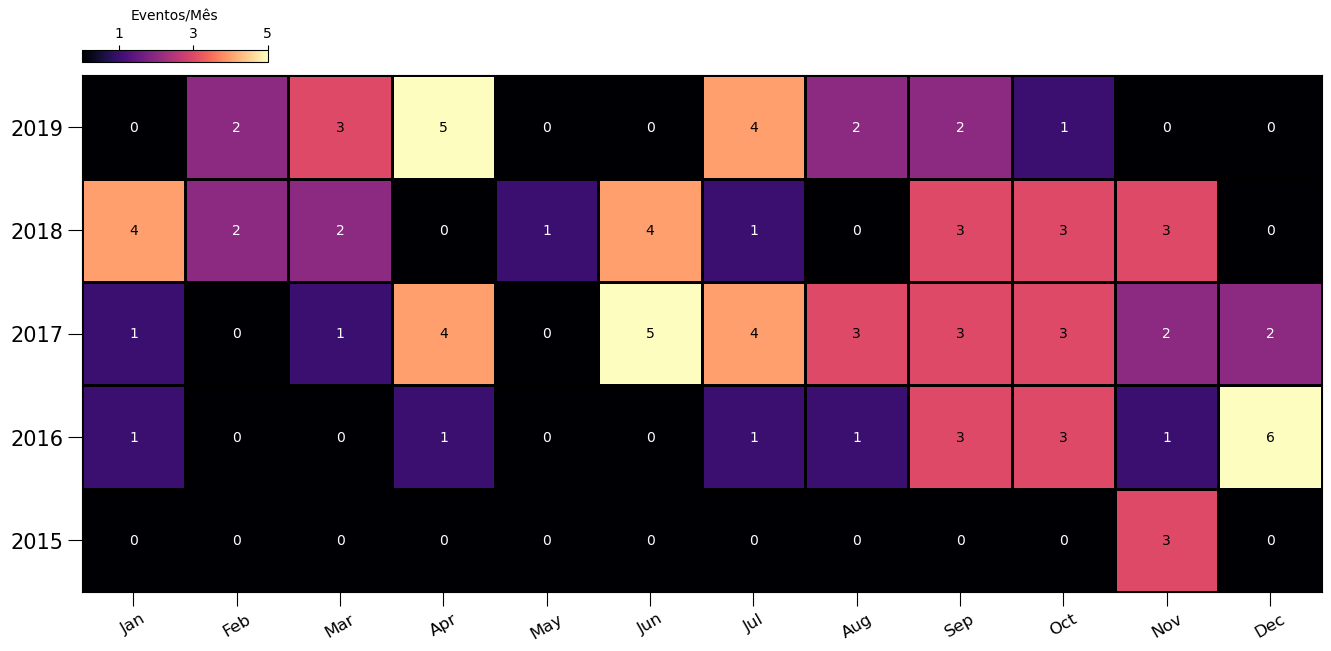

In [58]:
df_lst = []

for ev in tqdm(events_figures,total=len(events_figures)):
 
    t = ev.split('event_mseed_')[1].split('.png')[0].split('_')
    
    ev_time = UTCDateTime(datetime(int(t[0]),int(t[1]),int(t[2]),int(t[3]),int(t[4]),int(t[5])).isoformat())
    
    filename = '_'.join(t[6:])
        
    if 'pa' in filename.split('_')[0]:
        mergulho = filename.split('_')[0].split('a')[1]
        stream_number = filename.split('_')[1]

        year_month_day = filename.split('_')[2]
        hour_minute_second = filename.split('_')[3]

        year = int('20'+year_month_day[:2])
        month = int(year_month_day[2:4])
        day = int(year_month_day[4:])

        hour = int(hour_minute_second[:2])
        minute = int(hour_minute_second[2:4])
        second = int(hour_minute_second[4:])

    if 'pa' in filename.split('_')[2]:

        mergulho = filename.split('_')[2].split('a')[1]
        stream_number = filename.split('_')[3]

        year_month_day = filename.split('_')[0]
        hour_minute_second = filename.split('_')[1]

        year = int('20'+year_month_day[:2])
        month = int(year_month_day[2:4])
        day = int(year_month_day[4:])

        
        hour = int(hour_minute_second[:2])
        minute = int(hour_minute_second[2:4])
        second = int(hour_minute_second[4:])

    d = UTCDateTime(datetime(year,month,day,hour,minute,second).isoformat())
    
    #----------------------------
    #Starting Dataframe

    starttime = d.datetime
    hour_day = starttime.hour
    minute_day = starttime.minute
   
    df = pd.DataFrame([[filename],[mergulho],[stream_number],[starttime],[str(year)],[year_month_day[2:4]],[starttime.strftime("%b")]], index=['filename', 'mergulho', 'stream_number','starttime','year','month','name_month']).T
    #Ending Dataframe
    #----------------------------
    df_lst.append(df)

dataframe_final = pd.concat(df_lst, ignore_index=True)

month_date_lst = sorted(list(set(dataframe_final['month'].values)))

# creating the array to plot
dataframe_lista = []
for h in tqdm(np.arange(1,13),total=len(np.arange(1,13)), desc='Creating the dataframe:'):
    #try:

        df_month = dataframe_final[dataframe_final['month'] == str(h).zfill(2)]
            
        MONTH_LST = df_month['name_month'].values
        df_temp = [str(h).zfill(2),list(set(MONTH_LST))[0]]
        df_temp_index = ['number_month','name_month']
        for i in datetime_lista_years:
            if df_month['year'].str.contains(i).any():

                df_year = df_month[df_month['year'] == i]
                NUMBER_MINUTES_LST = df_year['year'].value_counts().values

                df_temp.append(NUMBER_MINUTES_LST[0])
                df_temp_index.append(i)
            else:
                df_temp.append(0)
                df_temp_index.append(i) 

        dataframe_lista.append(pd.DataFrame(df_temp, index=df_temp_index).T)
    #except:
       # pass

df_to_plot = pd.concat(dataframe_lista, ignore_index=True)

name_months = df_to_plot['name_month'].values
data_x_axis = df_to_plot[datetime_lista_years].values.astype(float).T
#-------------------------

# ==========================
# Plotting DATA availability
# ==========================
#x axis parameters

days = DayLocator(interval=1)  # every 1 day
months = MonthLocator(interval=1)  # every 1 month
monthsFmt = DateFormatter('%b-%y')

#Matplotlib parameters
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(16,9))

im = ax.pcolormesh(data_x_axis,cmap='magma', vmax=5,vmin=0,shading ='flat',ec='k')

# Get the dimensions of the array
rows, cols = data_x_axis.shape

# Loop over each cell and add the cell value as text
for i in range(rows):
    for j in range(cols):
        cell_value = int(data_x_axis[i, j])
        text_color = 'white' if cell_value < np.max(data_x_axis)/2 else 'black'
        ax.text(j + 0.5, i + 0.5, str(cell_value), color=text_color,ha='center', va='center')

# Set the tick locations and labels
# Set the x and y axis tick locations and labels
ax.set_xticks(np.arange(data_x_axis.shape[1]) + 0.5, name_months,fontsize=15)
ax.set_yticks(np.arange(data_x_axis.shape[0]) + 0.5, datetime_lista_years,fontsize=15)

ax.tick_params(which='minor', length=2)
ax.tick_params(which='major', length=10)
ax.set_aspect(1)

plt.setp(ax.xaxis.get_majorticklabels(), fontsize=12,rotation=30)

#criando a localização da barra de cores:
axins = inset_axes(ax,
                    width="15%",  # width = 15% of parent_bbox width
                    height="2.5%",  # height : 2.5%
                    loc='upper left',
                    bbox_to_anchor=(0.0, 0.05, 1, 1),
                    bbox_transform=ax.transAxes,
                    borderpad=0,
                    )
cbar = fig.colorbar(im, cax=axins, orientation="horizontal",ticks=[1,3,5] ,ticklocation='top',label='Eventos/Mês')

output_fig = FOLDER_OUTPUT+'FIGURAS/EVENTS_ALL/'
os.makedirs(output_fig,exist_ok='True')
fig.savefig(output_fig+'_events_all.png', dpi='figure')
 

In [56]:
sel_events_figures = glob.glob(SELECT_EVENTs_DATA_FOLDER+'*')

print("Found %s event(s)" % len(sel_events_figures))

Found 32 event(s)


Creating the dataframe:: 100%|█████████████████| 12/12 [00:00<00:00, 529.42it/s]


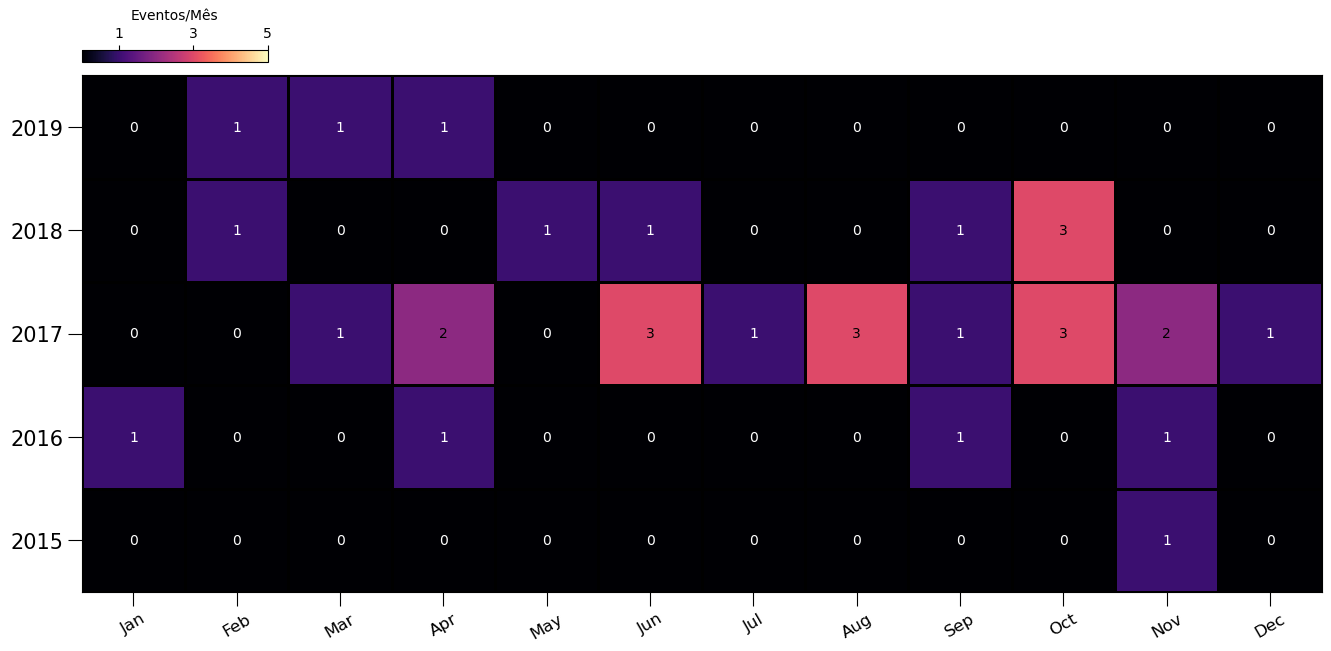

In [59]:
df_lst = []

for ev in tqdm(sel_events_figures,total=len(sel_events_figures)):
 
    t = ev.split('event_mseed_')[1].split('.png')[0].split('_')
    
    ev_time = UTCDateTime(datetime(int(t[0]),int(t[1]),int(t[2]),int(t[3]),int(t[4]),int(t[5])).isoformat())
    
    filename = '_'.join(t[6:])
        
    if 'pa' in filename.split('_')[0]:
        mergulho = filename.split('_')[0].split('a')[1]
        stream_number = filename.split('_')[1]

        year_month_day = filename.split('_')[2]
        hour_minute_second = filename.split('_')[3]

        year = int('20'+year_month_day[:2])
        month = int(year_month_day[2:4])
        day = int(year_month_day[4:])

        hour = int(hour_minute_second[:2])
        minute = int(hour_minute_second[2:4])
        second = int(hour_minute_second[4:])

    if 'pa' in filename.split('_')[2]:

        mergulho = filename.split('_')[2].split('a')[1]
        stream_number = filename.split('_')[3]

        year_month_day = filename.split('_')[0]
        hour_minute_second = filename.split('_')[1]

        year = int('20'+year_month_day[:2])
        month = int(year_month_day[2:4])
        day = int(year_month_day[4:])

        
        hour = int(hour_minute_second[:2])
        minute = int(hour_minute_second[2:4])
        second = int(hour_minute_second[4:])

    d = UTCDateTime(datetime(year,month,day,hour,minute,second).isoformat())
    
    #----------------------------
    #Starting Dataframe

    starttime = d.datetime
    hour_day = starttime.hour
    minute_day = starttime.minute
   
    df = pd.DataFrame([[filename],[mergulho],[stream_number],[starttime],[str(year)],[year_month_day[2:4]],[starttime.strftime("%b")]], index=['filename', 'mergulho', 'stream_number','starttime','year','month','name_month']).T
    #Ending Dataframe
    #----------------------------
    df_lst.append(df)

dataframe_final = pd.concat(df_lst, ignore_index=True)

month_date_lst = sorted(list(set(dataframe_final['month'].values)))

# creating the array to plot
dataframe_lista = []
for h in tqdm(np.arange(1,13),total=len(np.arange(1,13)), desc='Creating the dataframe:'):
    #try:

        df_month = dataframe_final[dataframe_final['month'] == str(h).zfill(2)]
            
        MONTH_LST = df_month['name_month'].values
        df_temp = [str(h).zfill(2),list(set(MONTH_LST))[0]]
        df_temp_index = ['number_month','name_month']
        for i in datetime_lista_years:
            if df_month['year'].str.contains(i).any():

                df_year = df_month[df_month['year'] == i]
                NUMBER_MINUTES_LST = df_year['year'].value_counts().values

                df_temp.append(NUMBER_MINUTES_LST[0])
                df_temp_index.append(i)
            else:
                df_temp.append(0)
                df_temp_index.append(i) 

        dataframe_lista.append(pd.DataFrame(df_temp, index=df_temp_index).T)
    #except:
       # pass

df_to_plot = pd.concat(dataframe_lista, ignore_index=True)

name_months = df_to_plot['name_month'].values
data_x_axis = df_to_plot[datetime_lista_years].values.astype(float).T
#-------------------------

# ==========================
# Plotting DATA availability
# ==========================
#x axis parameters

days = DayLocator(interval=1)  # every 1 day
months = MonthLocator(interval=1)  # every 1 month
monthsFmt = DateFormatter('%b-%y')

#Matplotlib parameters
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(16,9))

im = ax.pcolormesh(data_x_axis,cmap='magma', vmax=5,vmin=0,shading ='flat',ec='k')

# Get the dimensions of the array
rows, cols = data_x_axis.shape

# Loop over each cell and add the cell value as text
for i in range(rows):
    for j in range(cols):
        cell_value = int(data_x_axis[i, j])
        text_color = 'white' if cell_value < np.max(data_x_axis)/2 else 'black'
        ax.text(j + 0.5, i + 0.5, str(cell_value), color=text_color,ha='center', va='center')

# Set the tick locations and labels
# Set the x and y axis tick locations and labels
ax.set_xticks(np.arange(data_x_axis.shape[1]) + 0.5, name_months,fontsize=15)
ax.set_yticks(np.arange(data_x_axis.shape[0]) + 0.5, datetime_lista_years,fontsize=15)

ax.tick_params(which='minor', length=2)
ax.tick_params(which='major', length=10)
ax.set_aspect(1)

plt.setp(ax.xaxis.get_majorticklabels(), fontsize=12,rotation=30)

#criando a localização da barra de cores:
axins = inset_axes(ax,
                    width="15%",  # width = 15% of parent_bbox width
                    height="2.5%",  # height : 2.5%
                    loc='upper left',
                    bbox_to_anchor=(0.0, 0.05, 1, 1),
                    bbox_transform=ax.transAxes,
                    borderpad=0,
                    )
cbar = fig.colorbar(im, cax=axins, orientation="horizontal",ticks=[1,3,5] ,ticklocation='top',label='Eventos/Mês')

output_fig = FOLDER_OUTPUT+'FIGURAS/EVENTS_ALL/'
os.makedirs(output_fig,exist_ok='True')
fig.savefig(output_fig+'_events_selected.png', dpi='figure')
 